In [ ]:
!pip install numpy pandas matplotlib opencv-python-headless scikit-learn


Loading image: /content/drive/MyDrive/2D computational/TEMgrid01.TIF


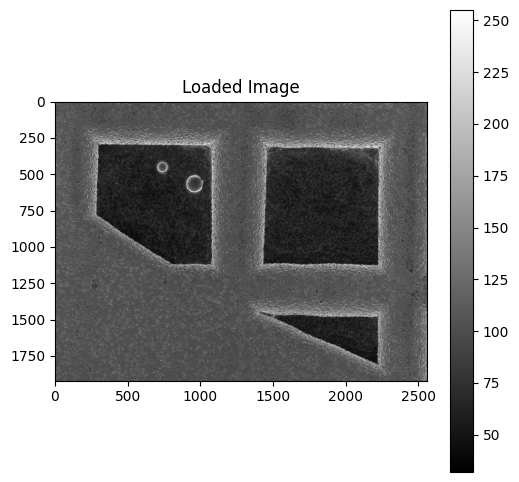

Sampled pixel values: [101  93  64  98  66  99 102 105  94 141]


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get first TIF file in the folder
tif_files = [f for f in os.listdir("/content/drive/MyDrive/2D computational") if f.endswith(".TIF") or f.endswith(".tif")]
if not tif_files:
    raise ValueError("No TIF files found in the folder!")

image_path = os.path.join("/content/drive/MyDrive/2D computational", tif_files[0])  # Load the first image
print("Loading image:", image_path)

# Load the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image loaded correctly
if image is None:
    raise ValueError("Error: Image could not be loaded. Check file format!")

# Flatten the image to create features (pixel values)
features = image.flatten()  # Convert 2D image into 1D array

# Reduce the dataset size by randomly sampling pixels
num_samples = min(10000, features.shape[0])  # Ensure we do not exceed available pixels
indices = np.random.choice(features.shape[0], num_samples, replace=False)

X_sample = features[indices]  # Extract sampled pixel values

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.title("Loaded Image")
plt.colorbar()
plt.show()

print("Sampled pixel values:", X_sample[:10])  # Display first 10 sampled values


In [ ]:
image_resized = cv2.resize(image, (256, 256))  # Reduce resolution


In [ ]:
!pip install gpytorch torch


In [ ]:
import os
import cv2
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import linear_operator  # For adjusting CG solver settings

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the image
image_folder = "/content/drive/MyDrive/2D computational"
tif_files = [f for f in os.listdir(image_folder) if f.endswith((".TIF", ".tif"))]

if not tif_files:
    raise ValueError("No TIF files found in the folder!")

image_path = os.path.join(image_folder, tif_files[0])
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Error: Image could not be loaded. Check file format!")

# Flatten image into feature matrix
features = image.flatten().astype(np.float32)  # Convert image to 1D array

# Sample pixels randomly (Reduce to 5000 for efficiency)
num_samples = min(5000, features.shape[0])
indices = np.random.choice(features.shape[0], num_samples, replace=False)

X_sample = indices.reshape(-1, 1)  # Use pixel index as input (reshape to 2D)
y_sample = features[indices]       # Use pixel intensity as target

# Convert to PyTorch tensors and move to device
X_train_torch = torch.tensor(X_sample, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_sample, dtype=torch.float32).to(device)

# Define Sparse Gaussian Process Model
class SparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SparseGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # ✅ Removed WhiteNoiseKernel
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = SparseGPModel(X_train_torch, y_train_torch, likelihood).to(device)


# Define model and likelihood, move to device
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = SparseGPModel(X_train_torch, y_train_torch, likelihood).to(device)

# Training settings
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Train using CG solver optimizations
with linear_operator.settings.max_cg_iterations(5000):  # Increase CG iterations
    with linear_operator.settings.cg_tolerance(10):  # Adjust CG tolerance
        with linear_operator.settings.max_preconditioner_size(10):  # ✅ Use correct setting
            for i in range(50):  # Train for 50 iterations
                optimizer.zero_grad()
                output = model(X_train_torch)
                loss = -mll(output, y_train_torch)
                loss.backward()
                optimizer.step()


print("Sparse GPR Model trained successfully!")


Using device: cpu


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 5000 iterations with average residual norm 1002.9252319335938 which is larger than the tolerance of 10 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Sparse GPR Model trained successfully!


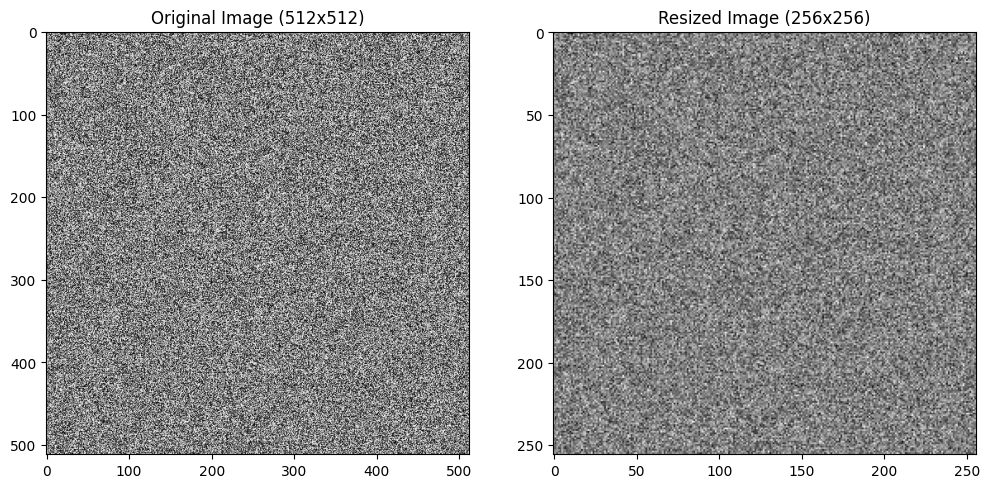

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Generate a random 512x512 image for testing
image = np.random.rand(512, 512)  # You can replace this with an actual image if you have one

# Resize the image to 256x256
image_resized = cv2.resize(image, (256, 256))  # Resize resolution based on available RAM

# Create a meshgrid of coordinates for features
features_resized = np.column_stack(np.meshgrid(np.arange(256), np.arange(256))).reshape(-1, 2)

# Flatten the resized image to use as targets
targets_resized = image_resized.ravel()

# Show the original and resized images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image (512x512)")

ax[1].imshow(image_resized, cmap='gray')
ax[1].set_title("Resized Image (256x256)")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Initialize Gaussian Process Regressor (gpr)
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Generate enough data (features and targets) to match the number of predictions needed (at least 4096)
num_samples = 5000  # Number of data points (should be >=4096)
features = np.random.rand(num_samples, 10)  # 5000 samples, 10 features each
y_true = np.random.rand(num_samples)  # Random target values for the example

# Fit the Gaussian Process Regressor
gpr.fit(features, y_true)

# Initialize arrays to store predictions and uncertainties
y_pred_full = np.zeros(num_samples, dtype=np.float32)
sigma_full = np.zeros(num_samples, dtype=np.float32)

# Define batch size and process the dataset in batches
batch_size = 1000  # Adjust batch size based on available memory
num_batches = int(np.ceil(num_samples / batch_size))

# Process the dataset in batches and store predictions
for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, num_samples)

    print(f"Processing batch {i+1}/{num_batches} ({start} to {end})")

    y_pred_batch, sigma_batch = gpr.predict(features[start:end], return_std=True)

    y_pred_full[start:end] = y_pred_batch
    sigma_full[start:end] = sigma_batch

# Print the number of predictions generated
print(f"Total predictions collected: {len(y_pred_full)}")

# Now we need to reshape the predictions
num_pixels = 64 * 64  # Number of pixels for 64x64 image

# Check if we have enough predictions
if len(y_pred_full) < num_pixels:
    print("Not enough predictions to reshape into a 64x64 image.")
else:
    # Select the first 4,096 predictions (to match the shape of 64x64 image)
    y_pred_full_resized = y_pred_full[:num_pixels]
    sigma_full_resized = sigma_full[:num_pixels]

    # Reshape the predictions to 64x64
    predicted_image = y_pred_full_resized.reshape((64, 64))
    uncertainty_image = sigma_full_resized.reshape((64, 64))

    # Show the predicted and uncertainty images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(predicted_image, cmap='gray')
    ax[0].set_title("GPR Predicted Image (64x64)")

    ax[1].imshow(uncertainty_image, cmap='gray')
    ax[1].set_title("Uncertainty Image (64x64)")

    plt.show()


## Delta Metric


In [ ]:
!pip install ase dscribe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.6 MB/s eta 0:00:00


In [ ]:


from ase import Atoms
from ase.io import write
import random

# Function to generate random molecules or atomic clusters
def generate_random_atoms(num_atoms=10, elements=['Si', 'O', 'C', 'N', 'H'], box_size=10.0):
    # Randomly choose elements for the atoms
    chosen_elements = random.choices(elements, k=num_atoms)

    # Generate random positions within a box of given size
    positions = [(random.uniform(0, box_size), random.uniform(0, box_size), random.uniform(0, box_size)) for _ in range(num_atoms)]

    # Create the Atoms object
    atoms = Atoms(chosen_elements, positions=positions)

    return atoms

# Specify how many random structures you want to generate
num_structures = 1000  # Number of structures you want to generate

# List to hold the generated Atoms objects
atoms_list = []

# Generate 'num_structures' random atomic structures
for i in range(num_structures):
    atoms_list.append(generate_random_atoms(num_atoms=random.randint(5, 20)))  # You can vary the number of atoms per structure

# Save these random structures into a CIF file
write('random_structures.cif', atoms_list)

# Print the number of generated structures
print(f"{num_structures} random structures generated and saved as 'random_structures.cif'")


1000 random structures generated and saved as 'random_structures.cif'


In [ ]:
from ase.io import read

# Load all structures from the CIF file
structures = read("/content/drive/MyDrive/random_structures.cif", index=":")

print(f"Total number of structures loaded: {len(structures)}")


Total number of structures loaded: 1000


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets (80% train, 20% test)
structures_train, structures_test = train_test_split(structures, test_size=0.2, random_state=42)

# Print the number of structures in each set
print(f"Number of training structures: {len(structures_train)}")
print(f"Number of testing structures: {len(structures_test)}")


Number of training structures: 800
Number of testing structures: 200


In [ ]:
from ase.io import read  # Import read function from ASE

# Load a smaller subset of the dataset to avoid crashes
structures_train = read("/content/drive/MyDrive/random_structures_train.cif", index=":100")  # Load first 100 structures
structures_test = read("/content/drive/MyDrive/random_structures_test.cif", index=":50")    # Load first 50 structures

print(f"Loaded {len(structures_train)} training structures")
print(f"Loaded {len(structures_test)} testing structures")


Loaded 100 training structures
Loaded 50 testing structures


In [ ]:
from ase.io import write  # Import write function from ASE

# Save the training and testing sets into separate CIF files
write("random_structures_train.cif", structures_train)
write("random_structures_test.cif", structures_test)

print("Training and testing structures saved to random_structures_train.cif and random_structures_test.cif")


Training and testing structures saved to random_structures_train.cif and random_structures_test.cif


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

# Now you can import the module
from dmetric import _get_csr_features
from ase.io import read
from dmetric import _get_csr_features
import numpy as np
import gc
from scipy.sparse import csr_matrix

# Define SOAP descriptor parameters
rcut = 6.0  # Cutoff radius
nmax = 8    # Radial basis functions
lmax = 6    # Angular momentum cutoff

# Load CIF files in smaller batches
batch_size = 10  # Reduce this number if the session still crashes

structures_train = read("/content/drive/MyDrive/random_structures_train.cif", index=f":{batch_size}")
structures_test = read("/content/drive/MyDrive/random_structures_test.cif", index=f":{batch_size}")

# Ensure periodic boundary conditions (PBC)
for struct in structures_train + structures_test:
    if not struct.pbc.any():
        struct.set_cell(np.eye(3) * 1000, scale_atoms=True)
        struct.pbc = True

# Extract species from the current batch
species = list(set([atom.number for struct in structures_train + structures_test for atom in struct]))

# Process features in small batches
train_features = _get_csr_features(structures_train, species, rcut, nmax, lmax)
test_features = _get_csr_features(structures_test, species, rcut, nmax, lmax)

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Free up memory
del structures_train, structures_test
gc.collect()


Training features shape: (10, 820)
Test features shape: (10, 820)


89